# COVID-19 Tracker
Using data on COVID-19 from the European Centre for Disease Control (via the website ourworldindata.org), and world population data from the World Bank, and the Python programming language and Jupyter (IPython) Notebook, I generated some charts to help visualize the data. You can skim the code below, and jumpt to the bottom to see the summary charts.

I have made this source code available as open source on the code sharing service GitHub (see https://github.com/bakirl/covid19-tracker) . You can also launch a Jupyter notebook live in your browser using the service called binder (see https://mybinder.org/v2/gh/bakirl/covid19-tracker/master) - this will take a few minutes to launch, after which you can click on the file (covid19.ipynb). Using this code, you can change things such as the countries and range of dates, etc.

## The Code

In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from datetime import datetime

In [2]:
# filter warnings, for now!
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download latest Covid 19 data
# location changed at end of nov
# world_df = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/full_data.csv")
world_df = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
# df.date is a string, convert to a datetime object
world_df['date'] = [datetime.strptime(date, '%Y-%m-%d') for date in world_df.date]

# Downloaded population from World Bank
# http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv
pop_df = pd.read_csv("population.csv", skiprows=4)
pop_df = pop_df.set_index('Country Name')
pop_df = pop_df['2018'].dropna()

In [4]:
# change name of Czech Republic
pop_df = pop_df.append(pd.Series([pop_df['Czech Republic']], index=['Czhechia']))
#[pop_df['Country Name'] == 'Czech Republic']

In [5]:
# Default values
values_def = 'new_cases'
start_def = '2020-03-01'
end_def = '2066-05-08' # i.e. no end date (way in the future)
#countries_def=['Italy','Spain','United Kingdom','Ireland','China','United States','Iran']
countries_def=[]

# Set the default size for the figures
plt.rcParams["figure.figsize"] = (14, 10)

In [6]:
# generate a pivot of values for a specified list of countries for a specified range of dates
# @param df - data frame containing Covid 19 data by date and by country
# @param pop - data frome containing population data from 2018
# @param values - one of 'new cases', 'total cases', 'new deaths', total deaths'
# @param start - show data only for dates since this date; format 'yyyy-mm-dd'
# @param locations - show data only for the specified locations
# @param by_pop - set to True to divide numbers by population per country, in 100K
def covid(df=world_df, pop=pop_df, values=values_def, start=start_def, end=end_def,
          locations=countries_def, by_pop=False, sort=True, world_strip=True):
    # filter by date
    df2 = df[df.date >= start]
    df2 = df2[df.date <= end]
    # generate a pivot chart
    piv = df2.pivot(index='date', columns='location', values=values)
    # filter by country
    if (locations == []):
        if (world_strip):
            sub = piv.drop(columns='World')
        else:
            sub = piv
    else:
        sub = piv[locations]
    # setup title of plot
    title=values + " from " + start
    if (by_pop):
        # divide each number by the population, in 100K
        if (locations == []):
            pop2=pop
        else:
            pop2 = pop[locations]
        pop2 = pop2/1e5
        #pop2 = pop2.transpose()
        #sub = sub/pop2.values
        sub = sub/pop2
        title = title + " per 100K of population"
    if (sort):
        # sort based on highest value on the most recent date (last row)
        lastrow = sub.shape[0]-1
        lastrow_name = sub.index[lastrow]
        sub.sort_values(by=lastrow_name, axis=1, ascending=False, inplace=True)
    return sub, title

In [7]:
# generate the sub-pivot for all countries in the covid dataframe
sub, title = covid(locations=[])

# not all countries in the covid dataframe are also in the population dataframe
# find the intersection of these two sets
countries_inter_index = pop_df.index.intersection(sub.columns)
countries_inter = countries_inter_index.values

In [8]:
# Countries with smaller populations are showing up - let's look at 40 countries with the smallest population
pop2=pop_df[countries_inter].sort_values(ascending=False)
entries=pop2.shape[0]

In [9]:
# Let's only consider countries with population greater than 1m
countries_small = pop2[pop2.values <= 1e6]
countries_large_index = countries_inter_index.difference(countries_small.index)
countries_large = countries_large_index.values

In [10]:
# renamed from 'Czech Republic' to 'Czechia'
countries_eu27=['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 
                 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
                 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovenia', 'Spain', 'Sweden']
# removed 'Slovakia', due to lack of population data
countries_europe = countries_eu27 + ['Albania', 'Andorra', 'Armenia', 'Azerbaijan', 'Belarus',
                                     'Bosnia and Herzegovina', 'Georgia', 'Iceland', 'Kazakhstan', 'Liechtenstein', 
                                     'Moldova', 'Monaco', 'Montenegro', 'Norway', 
                                     'San Marino', 'Serbia', 'Switzerland', 'Turkey', 'Ukraine', 'United Kingdom']
# 'North Macedonia', 'Russia', 'Vatican City'

In [11]:
def covid_plot1(df=world_df, pop=pop_df, n=10, locations=countries_inter, by_pop=False, sort=False, suptitle='', 
               start=start_def, end=end_def, normalized=False, rolling_window=7, major=14, sort_after=True, world_strip=True,
              values='new_cases', width=14, height=8, mult=1):
    plt.rcParams["figure.figsize"] = (width, height)
    fig, ax = plt.subplots(1, 1, linewidth=5, edgecolor='black')
    fig.tight_layout(pad=8)
    
    # setup figure title
    if (suptitle==''):
        suptitle = 'Top ' + str(n) + ' Locations'
    if (by_pop):
        suptitle += ', by Population'
    div = "\n"
    if (rolling_window != 1):
        suptitle += div + 'Moving Average over ' + str(rolling_window) + ' days'
        div = ', '
    if (normalized):
        suptitle += div + 'Normalized'
        div = ', '
    if (mult == 1):
        suptitle += ', per day'
    else:
        suptitle += ', per ' + str(mult) + ' days'
    fig.suptitle(suptitle, size=18, weight='bold')
    
    sub, title = covid(df=df, pop=pop, locations=locations, by_pop=by_pop, values=values, sort=sort, 
                       start=start, end=end, world_strip=world_strip)
    # set rolling window
    sub = sub.rolling(window=rolling_window).mean()
    sub = sub * mult
    if (normalized):
        sub = sub/sub.max(axis=0)
    if (sort_after):
        # resort at this point as normalization etc. affects order
        # sort based on highest value on the most recent date (last row)
        lastrow = sub.shape[0]-1
        lastrow_name = sub.index[lastrow]
        sub.sort_values(by=lastrow_name, axis=1, ascending=False, inplace=True)
    sub = sub.iloc[:, :n]
    ax1 = sub.plot(title=title, logy=False, ax=ax)
    ax1.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5, axis='both')
    ax1.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=major))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%e %b'))
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
    if (not normalized):
        ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

In [12]:
values_range_def = ['new_cases', 'total_cases', 'new_deaths', 'total_deaths']
# plot the data from the pivot in 4 charts, on for each of new cases, total cases, new deaths, total deaths
# @param n - show data from the top N countries
# @param locations - show data only for the specified locations
# @param by_pop - set to True to divide numbers by population per country, in 100K
# @param sort - if True, sort countries by highest value on last day
# @param suptitle - title to use for the set of 4 charts
# @param start_def - start date
# @param normalized - if True, normalize all values so that max value per country is 100%
#           Note, this is good for comparing the "shape"/slope of different countries with
#           very different absolute values.
# @param rolling_window - number of days over which to do a moving average
# @param major - major interval (in days) on x axis
def covid_plot4(df=world_df, pop=pop_df, n=10, locations=countries_inter, by_pop=False, sort=False, suptitle='', 
               start=start_def, end=end_def, normalized=False, rolling_window=7, major=14, sort_after=True, world_strip=True,
              values_range=values_range_def):
    plt.rcParams["figure.figsize"] = (14, 10)
    fig, ax = plt.subplots(2, 2, linewidth=5, edgecolor='black')
    fig.tight_layout(pad=8)
    
    # setup figure title
    if (suptitle==''):
        suptitle = 'Top ' + str(n) + ' Locations'
    if (by_pop):
        suptitle += ', by Population'
    div = "\n"
    if (rolling_window != 1):
        suptitle += div + 'Moving Average over ' + str(rolling_window) + ' days'
        div = ', '
    if (normalized):
        suptitle += div + 'Normalized'
        div = ', '
    fig.suptitle(suptitle, size=18, weight='bold')
    
    for values, axis in zip(values_range, [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]):
        sub, title = covid(df=df, pop=pop, locations=locations, by_pop=by_pop, values=values, sort=sort, 
                           start=start, end=end, world_strip=world_strip)
        # set rolling window
        sub = sub.rolling(window=rolling_window).mean()
        if (normalized):
            sub = sub/sub.max(axis=0)
        if (sort_after):
            # resort at this point as normalization etc. affects order
            # sort based on highest value on the most recent date (last row)
            lastrow = sub.shape[0]-1
            lastrow_name = sub.index[lastrow]
            sub.sort_values(by=lastrow_name, axis=1, ascending=False, inplace=True)
        sub = sub.iloc[:, :n]
        ax1 = sub.plot(title=title, logy=False, ax=axis)
        ax1.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5, axis='both')
        ax1.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
        ax1.xaxis.set_major_locator(mdates.DayLocator(interval=major))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%e %b'))
        for tick in ax1.get_xticklabels():
            tick.set_rotation(45)
        if (not normalized):
            ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}')) 

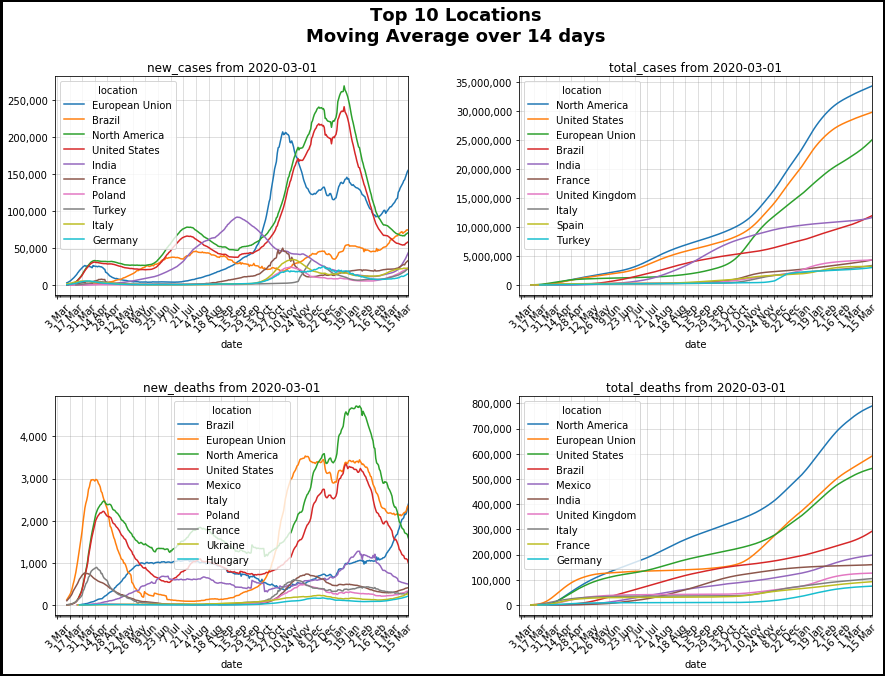

In [13]:
covid_plot4(rolling_window=14)

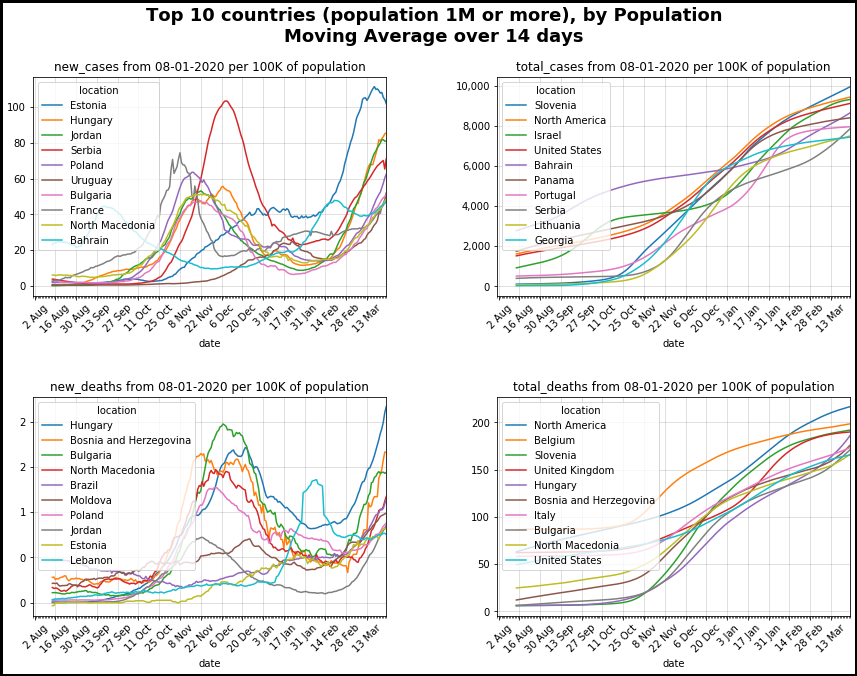

In [14]:
# when sorting by population, exclude smaller countries
covid_plot4(by_pop=True, locations=countries_large, suptitle="Top 10 countries (population 1M or more)", 
           start='08-01-2020', rolling_window=14)

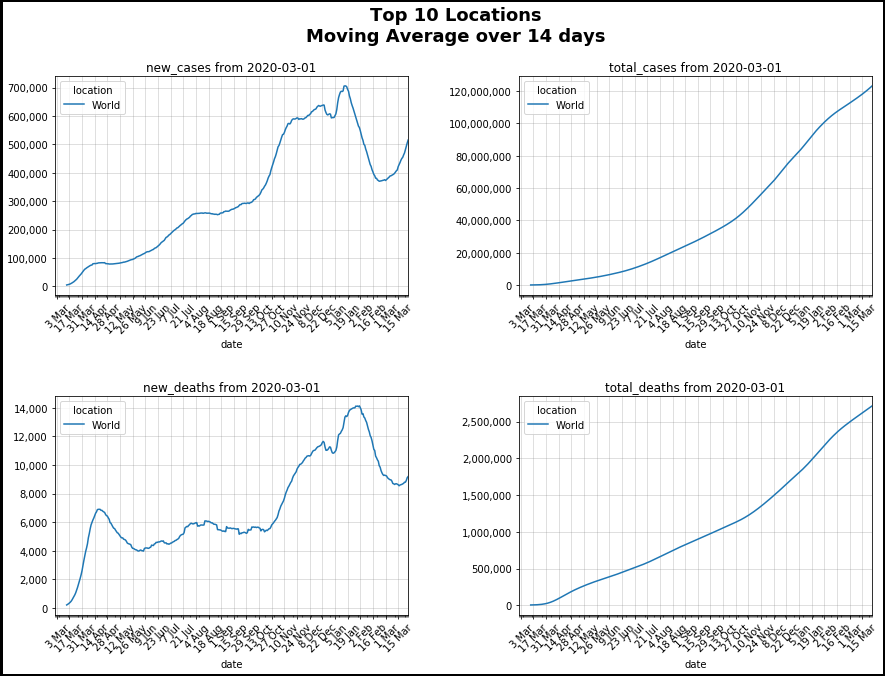

In [15]:
covid_plot4(locations=['World'], rolling_window=14)

In [16]:
# US data by state
us_df = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv")
us_df.rename(columns={'state': 'location', 'cases': 'total_cases', 'deaths': 'total_deaths'}, inplace=True)
us_df.drop(columns='fips', inplace=True)
# add new columns for new cases and deaths and populate by calculating diff over the corresponding totals
us_df['new_cases'] = 0
us_df['new_deaths'] = 0
for location in us_df.location.unique():
    us_df.loc[us_df.location == location, ['new_cases']] = us_df[us_df.location == location]['total_cases'].diff()
    us_df.loc[us_df.location == location, ['new_deaths']] = us_df[us_df.location == location]['total_deaths'].diff()
# df.date is a string, convert to a datetime object
us_df['date'] = [datetime.strptime(date, '%Y-%m-%d') for date in us_df.date]

In [17]:
us_pop_df = pd.read_csv("http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv")
us_pop_df.rename(columns={'NAME': 'location'})
us_pop_df.set_index('NAME', inplace=True)
us_pop_df = us_pop_df['POPESTIMATE2019']

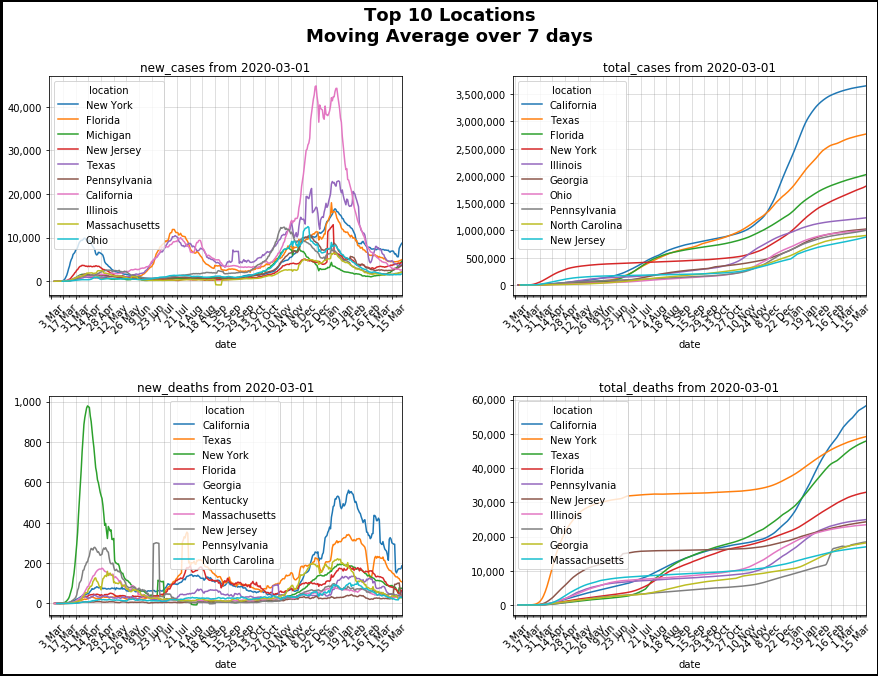

In [18]:
covid_plot4(df=us_df, locations=[], rolling_window=7, world_strip=False)

In [19]:
# Ireland data by county
#ie_df = pd.read_csv("https://opendata.arcgis.com/datasets/d9be85b30d7748b5b7c09450b8aede63_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D")
ie_df = pd.read_csv("https://opendata.arcgis.com/datasets/d9be85b30d7748b5b7c09450b8aede63_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D")

ie_df.rename(columns={'CountyName': 'location', 'ConfirmedCovidCases': 'total_cases', 'ConfirmedCovidDeaths': 'total_deaths'}, inplace=True)
#ie_df.drop(columns=['OBJECTID', 'ORIGID', 'IGEasting', 'IGNorthing', 'Lat', 'Long'], inplace=True)
#ie_df.drop(columns=['UGI', 'PopulationProportionCovidCases', 'ConfirmedCovidRecovered', 'SHAPE_Area', 'SHAPE_Length'], inplace=True)
# add new columns for new cases and deaths and populate by calculating diff over the corresponding totals
ie_df['new_cases'] = 0
ie_df['new_deaths'] = 0
for location in ie_df.location.unique():
    ie_df.loc[ie_df.location == location, ['new_cases']] = ie_df[ie_df.location == location]['total_cases'].diff()
    ie_df.loc[ie_df.location == location, ['new_deaths']] = ie_df[ie_df.location == location]['total_deaths'].diff()
# df.TimeStamp is a string, convert to a datetime object
ie_df['date'] = ''
ie_df['date'] = [datetime.strptime(date[:10], '%Y/%m/%d') for date in ie_df.TimeStamp]
ie_df.drop(columns=['TimeStamp'], inplace=True)

In [20]:
# add rows for totals, with location labeled 'Ireland'
for date in ie_df.date.unique():
    total_cases = ie_df[ie_df.date == date].total_cases.sum()
    total_pop = ie_df[ie_df.date == date].PopulationCensus16.sum()
    total_row = pd.DataFrame([[date, 'Ireland', total_cases, total_pop]], 
                             columns=['date', 'location', 'total_cases', 'PopulationCensus16'])
#    ie_df = ie_df.append(total_row)
#    
#ie_df.sort_values(by='date', axis=0, ascending=True, inplace=True)

In [21]:
ie_df.head(30)

,OBJECTID,ORIGID,location,PopulationCensus16,IGEasting,IGNorthing,Lat,Long,UGI,total_cases,PopulationProportionCovidCases,total_deaths,ConfirmedCovidRecovered,Shape__Area,Shape__Length,new_cases,new_deaths,date
0,1,1,Carlow,56932,278661,163444,52.7168,-6.8367,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,2.432352e+09,3.193486e+05,NaN,NaN,2020-02-27
1,2,2,Cavan,76176,246380,304501,53.9878,-7.2937,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,5.575010e+09,5.159545e+05,NaN,NaN,2020-02-27
2,3,3,Clare,118817,133493,182732,52.8917,-8.9889,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,8.722542e+09,1.013949e+06,NaN,NaN,2020-02-27
3,4,4,Cork,542868,156242,77860,51.9517,-8.6372,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,1.952949e+10,2.129949e+06,NaN,NaN,2020-02-27
4,5,5,Donegal,159192,202615,405691,54.8989,-7.9600,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,1.462404e+10,2.145086e+06,NaN,NaN,2020-02-27
5,6,6,Dublin,1347359,313762,235813,53.3605,-6.2920,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,2.612633e+09,4.494335e+05,NaN,NaN,2020-02-27
6,7,7,Galway,258058,151045,235818,53.3705,-8.7362,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,1.707916e+10,1.972288e+06,NaN,NaN,2020-02-27
7,8,8,Kerry,147707,92975,102996,52.1689,-9.5650,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,1.248360e+10,1.753780e+06,NaN,NaN,2020-02-27
8,9,9,Kildare,222504,281262,221513,53.2380,-6.7837,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,4.726064e+09,4.221820e+05,NaN,NaN,2020-02-27
9,10,10,Kilkenny,99232,253094,148060,52.5816,-7.2175,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,5.585392e+09,4.533976e+05,NaN,NaN,2020-02-27


In [22]:
# Looks like this error has been fixed!!!

# Turns out there's a duplicate set of rows on 29 June for some reason, 
# which prevents us from generating a pivot table.
# There's also a missing date (30 Jun); just removing the duplicate
# causes an issue with setting the "locators" on the axis.
# Instead, we change date on second 29 Jun data points to 30 Jun.
from datetime import timedelta

prev_date=datetime.today()
for location in ie_df.location.unique():
    for date in ie_df[ie_df.location==location].date:
        if (date==prev_date):
            print(f"Duplicate: location={location}, date={str(date)[:10]}")
            next_date = date+timedelta(days=1)
        prev_date = date

# next date should be 30 Jun
# next_date

# set max_rows to None (default 10) to see all rows
# pd.set_option('display.max_rows', None)
# ie_df[ie_df.date=='2020-06-30']

#ie_df = ie_df.drop_duplicates(['location','date'], keep= 'first')
# 
# replace duplicates (29 Jun) with the following date (30 Jun)
#ie_df.loc[ie_df.duplicated(['location', 'date']), ['date']] = next_date

In [23]:
# extract population of Ireland by county
ie_pop_df = ie_df[ie_df.date=='2020-06-30'].set_index('location')
ie_pop_df = ie_pop_df['PopulationCensus16']
#ie_pop_df.drop(columns=['total_cases', 'total_deaths', 'new_cases', 'new_deaths', 'date'], inplace=True)

all_counties = ie_df.location.unique()

In [24]:
def covid_piv1(df=world_df, pop=pop_df, n=10, locations=countries_inter, by_pop=False, sort=False, 
               start=start_def, normalized=False, rolling_window=14, sort_after=True, world_strip=True,
              values='new_cases', mult=14):
    sub, title = covid(df=df, pop=pop, locations=locations, by_pop=by_pop, values=values, sort=sort, 
                       start=start, world_strip=world_strip)
    # set rolling window
    sub = sub.rolling(window=rolling_window).mean()
    sub = sub * mult
    if (normalized):
        sub = sub/sub.max(axis=0)
    if (sort_after):
        # resort at this point as normalization etc. affects order
        # sort based on highest value on the most recent date (last row)
        lastrow = sub.shape[0]-1
        lastrow_name = sub.index[lastrow]
        sub.sort_values(by=lastrow_name, axis=1, ascending=False, inplace=True)
    sub = sub.iloc[:, :n]
    return sub

def covid_tab1(df=world_df, pop=pop_df, n=10, locations=countries_inter, by_pop=False, sort=False, 
               start=start_def, normalized=False, rolling_window=14, sort_after=True, world_strip=True,
              values='new_cases', mult=14, round=1, sort_by_delta=False):
    piv = covid_piv1(df=df, pop=pop, by_pop=by_pop, locations=locations, world_strip=world_strip, 
                     start=start, 
                     rolling_window=rolling_window, n=n, mult=mult)
    piv_t = piv.tail(1).round(1).transpose()
    piv_diff_t = piv.diff().tail(1).round(1).transpose()
    piv_diff_t.rename(columns={piv_diff_t.columns[-1]: 'Delta (since previous day)'}, inplace=True)
    piv2 = pd.concat([piv_t, piv_diff_t], axis=1, sort=False)
    title = f'Rate per 100,000, moving average over {rolling_window} days'
    if (sort_by_delta):
        piv2.sort_values(by='Delta (since previous day)', axis=0, ascending=False, inplace=True)
        title += ', sorted by delta'
    print(title)
    print(piv2)

In [25]:
covid_tab1(locations=countries_large, sort_by_delta=True, by_pop=True, n=30)

Rate per 100,000, moving average over 14 days, sorted by delta
date                    2021-03-27 00:00:00  Delta (since previous day)
location                                                               
Serbia                                996.4                        80.6
Uruguay                               729.0                        54.4
Ukraine                               433.8                        36.0
Poland                                875.1                        28.2
Slovenia                              589.4                        19.6
France                                692.1                        19.2
Bahrain                               663.5                        18.2
Turkey                                380.3                        18.1
Belgium                               531.8                        15.2
Netherlands                           562.7                        15.2
North Macedonia                       678.0                        13.9
A

In [26]:
# Some countries don't seem to report on latest date, e.g. Spain, Sweden - see logic below
# as a result, plot based on previous date
import numpy as np

total_countries = world_df.location.unique()
total_num = total_countries.shape[0]

latest_date = world_df.loc[world_df.shape[0]-1].date
latest_countries = world_df[world_df.date == latest_date].location
latest_num = latest_countries.shape[0]
latest_miss = np.setdiff1d(total_countries, latest_countries)

prev_date = latest_date - timedelta(days=1)
prev_countries = world_df[world_df.date == prev_date].location
prev_num = prev_countries.shape[0]
prev_miss = np.setdiff1d(total_countries, prev_countries)

print(f'total = {total_num}, latest = {latest_num}, missing {latest_miss}, prev = {prev_num}, missing {prev_miss}')

total = 215, latest = 203, missing ['Anguilla' 'Bermuda' 'Cayman Islands' 'Falkland Islands' 'Greenland'
 'Guernsey' 'Isle of Man' 'Jersey' 'Montserrat' 'Northern Cyprus'
 'Saint Helena' 'Turks and Caicos Islands'], prev = 203, missing ['Anguilla' 'Bermuda' 'Cayman Islands' 'Falkland Islands' 'Greenland'
 'Guernsey' 'Isle of Man' 'Jersey' 'Montserrat' 'Northern Cyprus'
 'Saint Helena' 'Turks and Caicos Islands']


In [27]:
ie_df.tail(26).sort_values(by='new_cases', ascending=False)

,OBJECTID,ORIGID,location,PopulationCensus16,IGEasting,IGNorthing,Lat,Long,UGI,total_cases,PopulationProportionCovidCases,total_deaths,ConfirmedCovidRecovered,Shape__Area,Shape__Length,new_cases,new_deaths,date
10145,10146,6,Dublin,1347359,313762,235813,53.3605,-6.2920,http://data.geohive.ie/resource/county/2ae1962...,81753,6067.647895,NaN,NaN,2.612633e+09,4.494335e+05,212.0,NaN,2021-03-25
10148,10149,9,Kildare,222504,281262,221513,53.2380,-6.7837,http://data.geohive.ie/resource/county/2ae1962...,10724,4819.688635,NaN,NaN,4.726064e+09,4.221820e+05,44.0,NaN,2021-03-25
10158,10159,19,Offaly,77961,222690,223679,53.2632,-7.6607,http://data.geohive.ie/resource/county/2ae1962...,3843,4929.387771,NaN,NaN,5.558826e+09,5.614404e+05,33.0,NaN,2021-03-25
10156,10157,17,Meath,195044,284946,271349,53.6851,-6.7150,http://data.geohive.ie/resource/county/2ae1962...,9775,5011.689670,NaN,NaN,6.658571e+09,5.548448e+05,31.0,NaN,2021-03-25
10163,10164,24,Westmeath,88770,238362,255966,53.5524,-7.4219,http://data.geohive.ie/resource/county/2ae1962...,3455,3892.080658,NaN,NaN,5.208706e+09,4.226693e+05,29.0,NaN,2021-03-25
10144,10145,5,Donegal,159192,202615,405691,54.8989,-7.9600,http://data.geohive.ie/resource/county/2ae1962...,9042,5679.933665,NaN,NaN,1.462404e+10,2.145086e+06,26.0,NaN,2021-03-25
10146,10147,7,Galway,258058,151045,235818,53.3705,-8.7362,http://data.geohive.ie/resource/county/2ae1962...,9830,3809.221183,NaN,NaN,1.707916e+10,1.972288e+06,24.0,NaN,2021-03-25
10164,10165,25,Wexford,149722,301627,141559,52.5164,-6.5037,http://data.geohive.ie/resource/county/2ae1962...,6836,4565.795274,NaN,NaN,6.332221e+09,5.893245e+05,21.0,NaN,2021-03-25
10152,10153,13,Limerick,194899,149743,141780,52.5255,-8.7412,http://data.geohive.ie/resource/county/2ae1962...,10892,5588.535600,NaN,NaN,7.206727e+09,6.738927e+05,21.0,NaN,2021-03-25
10154,10155,15,Louth,128884,299463,297349,53.9161,-6.4870,http://data.geohive.ie/resource/county/2ae1962...,8769,6803.792558,NaN,NaN,2.386327e+09,3.522035e+05,19.0,NaN,2021-03-25


# Summary

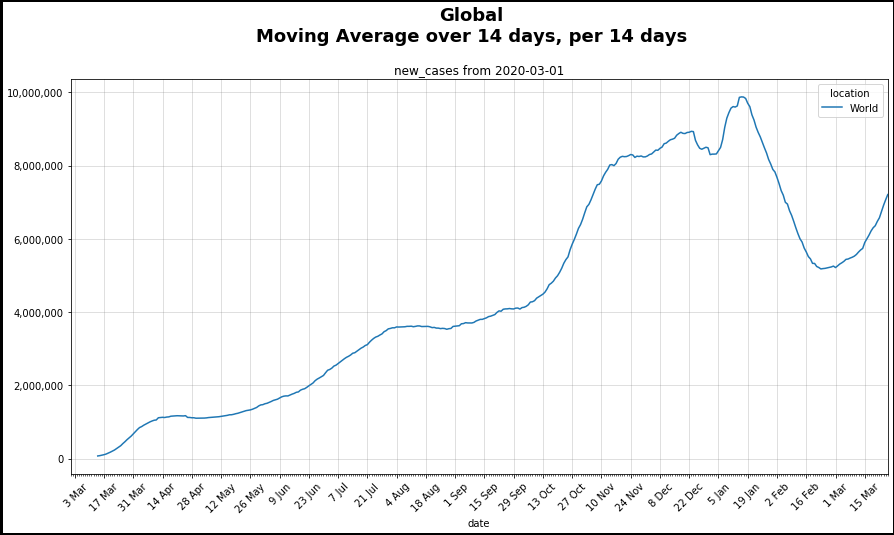

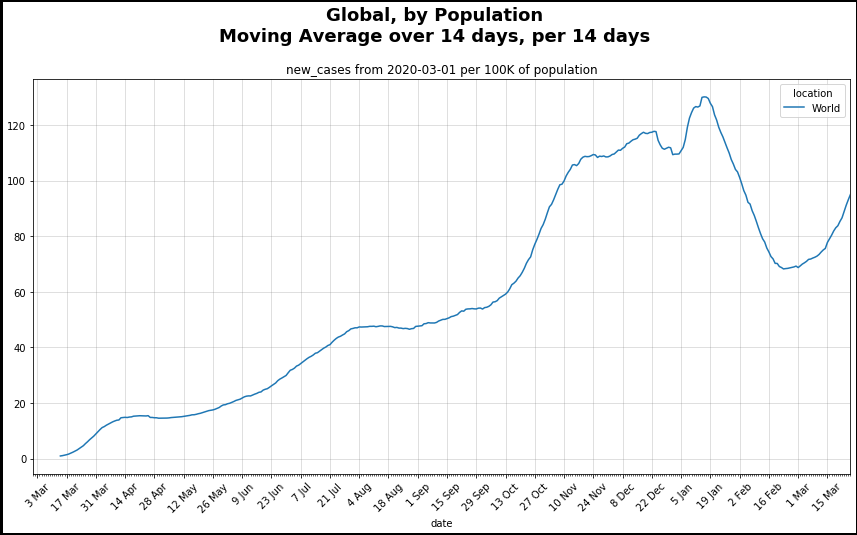

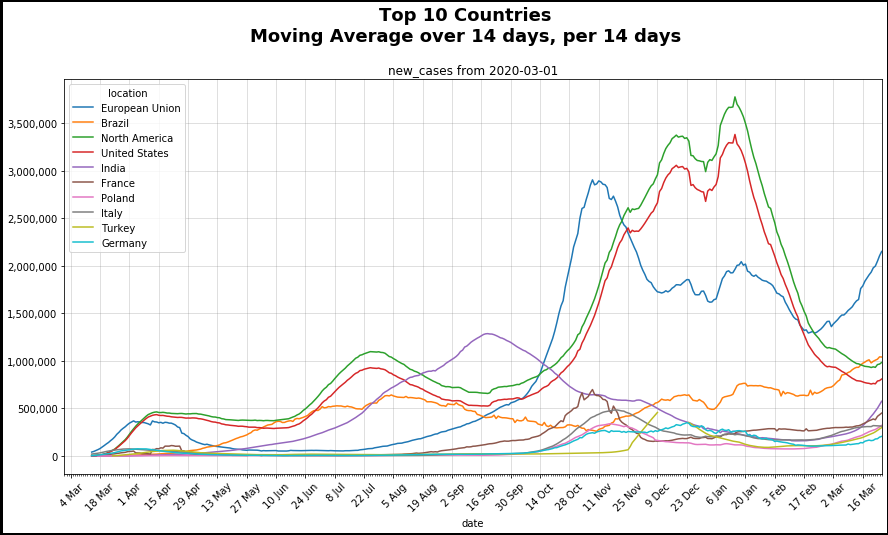

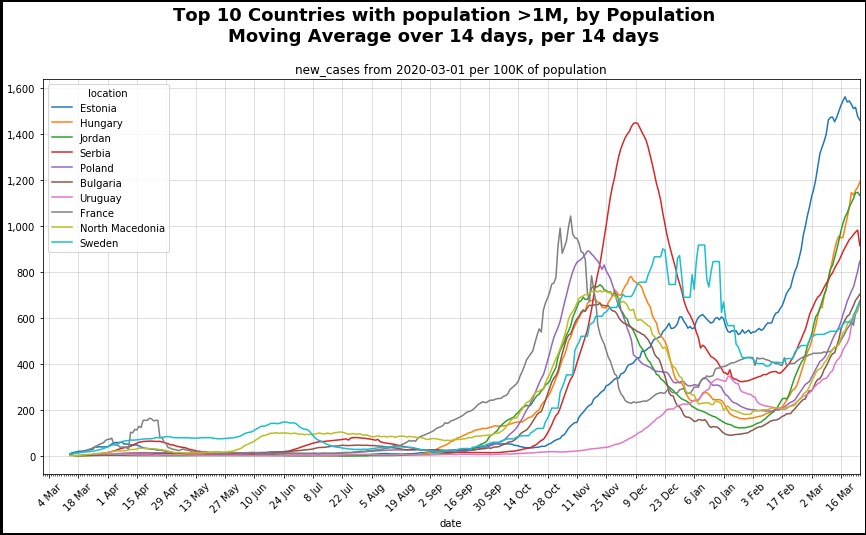

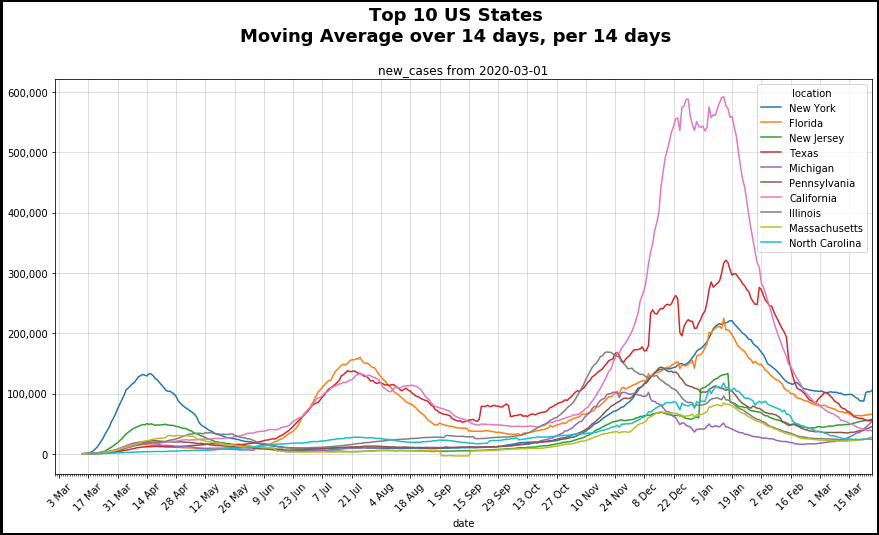

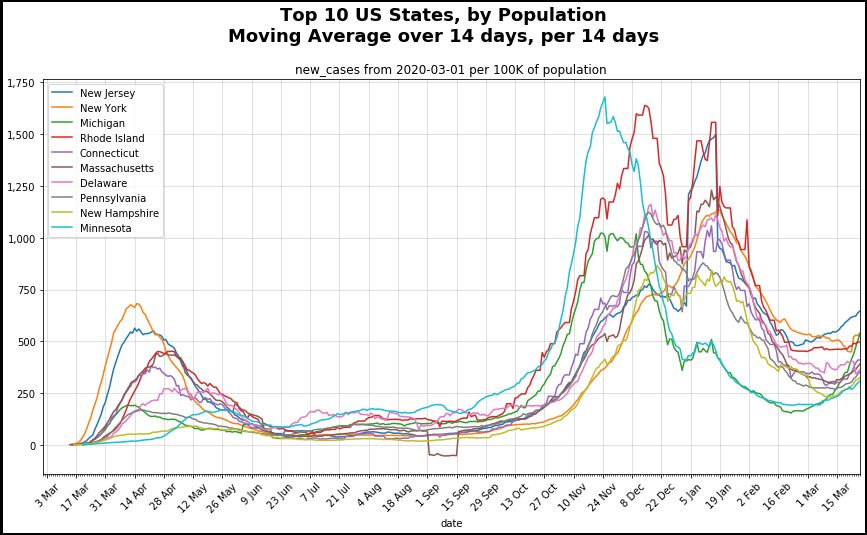

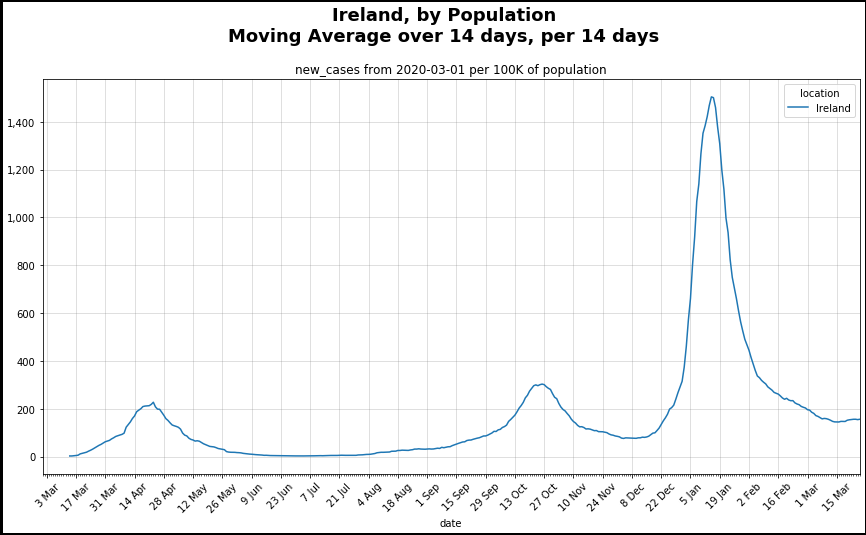

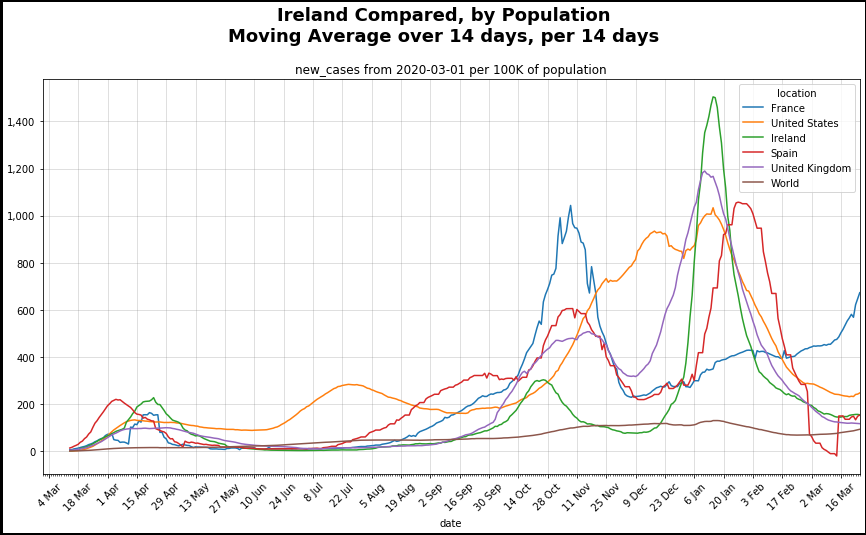

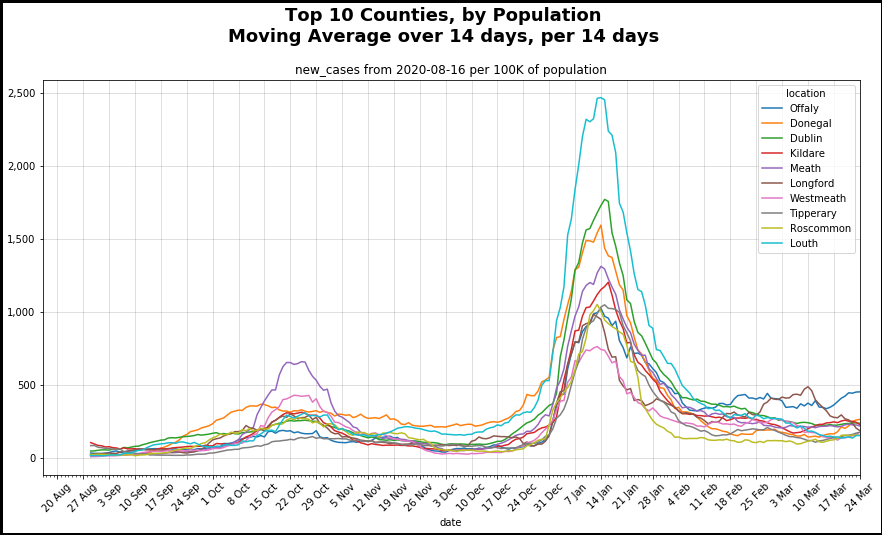

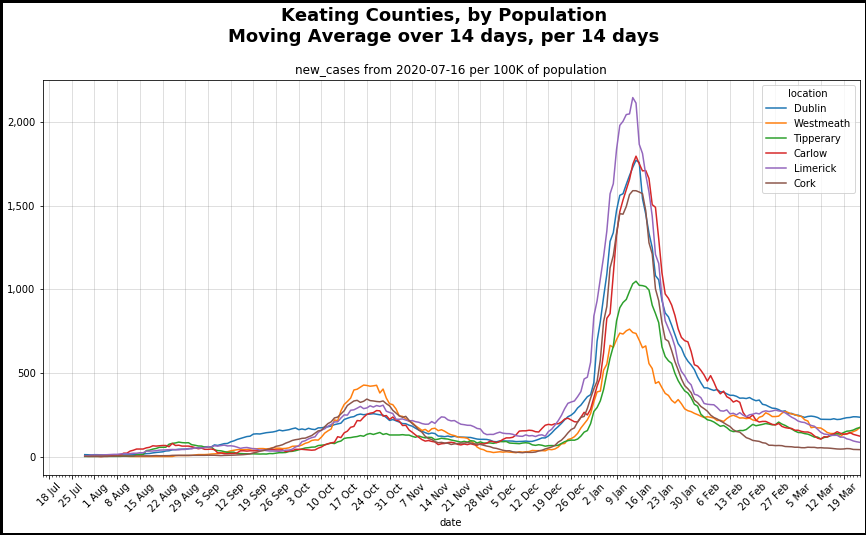

In [28]:
covid_plot1(rolling_window=14, mult=14, locations=['World'], suptitle="Global")
covid_plot1(rolling_window=14, mult=14, locations=['World'], suptitle="Global", by_pop=True)
covid_plot1(rolling_window=14, mult=14, suptitle="Top 10 Countries", 
            end=prev_date)
covid_plot1(rolling_window=14, mult=14, by_pop=True, 
            locations=countries_large, 
            suptitle="Top 10 Countries with population >1M", 
            end=prev_date)
covid_plot1(df=us_df, locations=[], world_strip=False, rolling_window=14, mult=14, suptitle='Top 10 US States')
covid_plot1(df=us_df, pop=us_pop_df, by_pop=True, locations=[], world_strip=False, rolling_window=14, mult=14, 
            suptitle='Top 10 US States')
#covid_plot1(rolling_window=14, mult=14, 
#            locations=countries_eu27, suptitle="Top 10 Countries in EU27", 
#            end=prev_date, by_pop=True) 
covid_plot1(rolling_window=14, mult=14, 
            locations=['Ireland'], suptitle="Ireland", 
            by_pop=True)
covid_plot1(rolling_window=14, mult=14, 
            locations=['Ireland', 'World', 'United States', 'United Kingdom', 'Spain', 'France'], suptitle="Ireland Compared", 
            end=prev_date, by_pop=True)
covid_plot1(df=ie_df, pop=ie_pop_df, by_pop=True, locations=[], world_strip=False, 
            rolling_window=14, mult=14, suptitle='Top 10 Counties', 
            start='2020-08-16', major=7)
covid_plot1(df=ie_df, pop=ie_pop_df, by_pop=True, locations=['Tipperary', 'Carlow', 'Cork', 'Dublin', 'Westmeath', 'Limerick'], world_strip=False, 
            start='2020-07-16', rolling_window=14, mult=14, major=7,
            #width=14, height=8, 
            n=10, suptitle='Keating Counties')

In [29]:
covid_tab1(df=ie_df, pop=ie_pop_df, by_pop=True, locations=[], world_strip=False, start='2020-07-18', 
                 rolling_window=14, n=26, mult=14, round=1)
covid_tab1(df=us_df, pop=us_pop_df, by_pop=True, locations=[], world_strip=False, start='2020-07-18', 
                 rolling_window=14, n=50, mult=14, round=1)

Rate per 100,000, moving average over 14 days
date       2021-03-25 00:00:00  Delta (since previous day)
location                                                  
Offaly                   451.5                         1.3
Donegal                  262.6                         4.4
Dublin                   236.0                        -2.3
Kildare                  227.0                       -16.2
Meath                    217.4                        -7.2
Longford                 185.9                       -17.1
Westmeath                174.6                        16.9
Tipperary                174.2                         5.6
Roscommon                154.9                         1.5
Louth                    152.1                         0.8
Wexford                  146.3                         8.7
Waterford                137.7                         5.2
Galway                   130.6                        -3.5
Laois                    129.9                        13.0
Carlow    

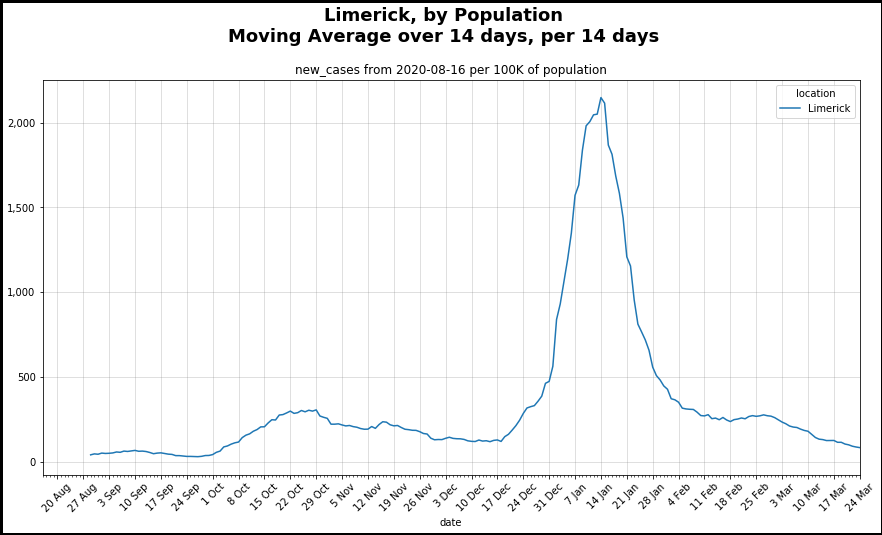

In [30]:
covid_plot1(df=ie_df, pop=ie_pop_df, by_pop=True, locations=['Limerick'], world_strip=False, 
            rolling_window=14, mult=14, suptitle='Limerick',
            start='2020-08-16', major=7)


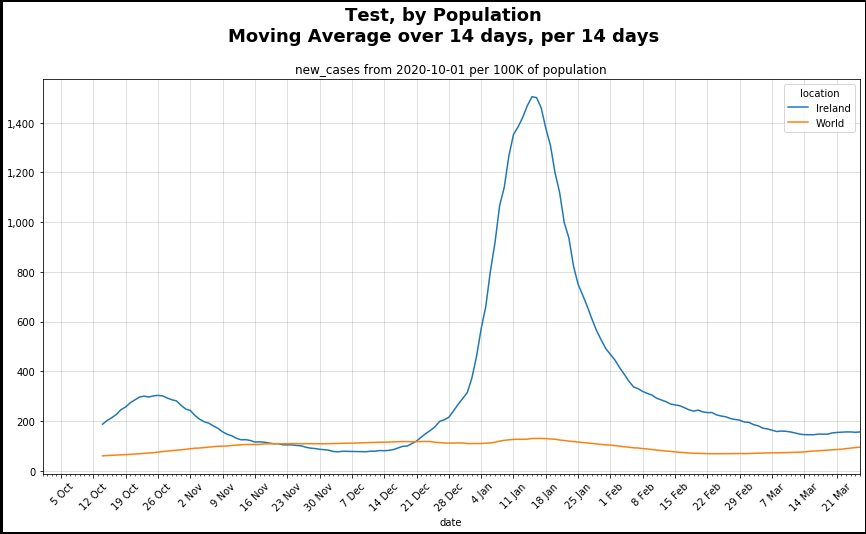

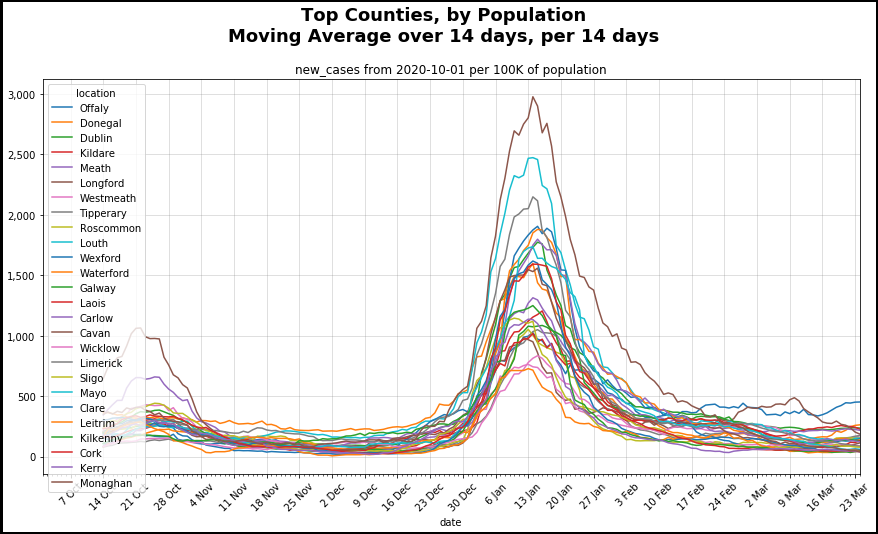

In [31]:
covid_plot1(by_pop=True, locations=['Ireland', 'World'],
            rolling_window=14, mult=14, suptitle='Test', 
            start='2020-10-01', major=7)
covid_plot1(df=ie_df, pop=ie_pop_df, by_pop=True, locations=[], world_strip=False, 
            rolling_window=14, mult=14, suptitle='Top Counties', 
            start='2020-10-01', major=7, n=26)
#covid_plot1(df=ie_df, pop=ie_pop_df, by_pop=True, locations=['Tipperary', 'Carlow', 'Cork', 'Dublin', 'Westmeath', 'Limerick'], world_strip=False, 
#            start='2020-09-01', rolling_window=14, mult=14, major=7,
#            #width=14, height=8, 
#            n=10, suptitle='Keating Counties')

In [32]:
covid_tab1(sort_by_delta=True)

Rate per 100,000, moving average over 14 days, sorted by delta
date            2021-03-27 00:00:00  Delta (since previous day)
location                                                       
India                      612576.0                     37394.0
European Union            2179141.0                     28394.0
Turkey                     313103.0                     14939.0
France                     463637.0                     12842.0
Poland                     332365.0                     10696.0
Brazil                    1050804.0                      9770.0
North America              992485.0                      9376.0
United States              818130.0                      8847.0
Germany                    213061.0                      7060.0
Italy                      310615.0                     -2197.0
